 # Making Business Decisions Based on Data Project

## Project description

You are an analyst at a big online store. Together with the marketing department, you've compiled a list of hypotheses that may help boost revenue.
You need to prioritize these hypotheses, launch an A/B test, and analyze the results.

## Research plan:

1. **[Downloading](#section0) and preprocessing the data  [conclusions](#section0c)**

### Part 1. Prioritizing Hypotheses

  1. **[ICE](#section1_1) framework [conclusions](#section1_1c)**;
  2. **[RICE](#section1_2) framework [conclusions](#section1_2c)**;
  3. **How the [prioritization of hypotheses changes](#section1_3) when you use RICE instead of ICE  [conclusions](#section1_3c)**
    
### Part 2. A/B Test Analysis

  1. **[Cumulative revenue](#section2_1) by group  [conclusions](#section2_1c)**;
  2. **[Cumulative average order size](#section2_2) by group  [conclusions](#section2_2c)**;
  3. **[Relative difference](#section2_3) in cumulative average order size  [conclusions](#section2_3c)**;
  4. **[Cumulative conversion rate](#section2_4) of the two groups  [conclusions](#section2_4c)**;
        **NEW! [Relative gain in conversion](#section2_4_0) in group B compared with group A  [conclusions](#section2_4_0c)**;
  5. **[Number of orders per user](#section2_5)  [conclusions](#section2_5c)**;
  6. **[When](#section2_6) data on number of orders per user becomes an anomaly  [conclusions](#section2_6c)**;
  7. **[Order prices](#section2_7)  [conclusions](#section2_7c)**;
  8. **[When](#section2_8) data on order prices becomes an anomaly  [conclusions](#section2_8c)**;
  9. **[Statistical significance](#section2_9) of the difference in conversion between the groups (raw data)  [conclusions](#section2_9c)**;
  10. **[Statistical significance](#section2_10) of the difference in average order size between the groups (raw data)  [conclusions](#section2_10c)**;
  11. **[Statistical significance](#section2_11) of the difference in conversion between the groups (filtered data)  [conclusions](#section2_11c)**;
  12. **[Statistical significance](#section2_12) of the difference in average order size between the groups (filtered data)  [conclusions](#section2_12c)**;
  13. **[Decision](#section2_13) based on the test result  [conclusions](#section2_13c)**
    

<a id="section0"></a>

## Downloading and preprocessing the data

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('max_colwidth', 120)

In [4]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

In [5]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Effort        9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
visits = pd.read_csv('/datasets/visits_us.csv' , parse_dates = ['date'])

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null datetime64[ns]
group     62 non-null object
visits    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
visits.sample(5)

,date,group,visits
51,2019-08-21,B,656
2,2019-08-03,A,507
10,2019-08-11,A,718
35,2019-08-05,B,707
58,2019-08-28,B,654


In [9]:
orders = pd.read_csv('/datasets/orders_us.csv', parse_dates = ['date'])

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null float64
group            1197 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [11]:
orders.sample(5)

,transactionId,visitorId,date,revenue,group
51,794298435,2914239125,2019-08-16,280.5,B
622,2148936881,654930236,2019-08-29,300.6,B
301,2070211595,3294921142,2019-08-03,90.5,A
471,798048333,3462462738,2019-08-03,40.3,A
153,4045393544,991436984,2019-08-01,30.5,A


In [12]:
#creating lists of group A and group B users to compare

usersAList = orders[orders['group'] == "A"].agg({'visitorId':'unique'})
print('Users in group A:', len(usersAList))

usersBList = orders[orders['group'] == "B"].agg({'visitorId':'unique'})
print('Users in group B:', len(usersBList))

Users in group A: 503
Users in group B: 586


In [13]:
#checking whether there are users presented in both A and B group

print('Number of users presented in both groups:', len(usersBList[usersBList['visitorId'].isin(usersAList['visitorId'])]))
print('Percentage of these users: {:.2%}'.format(len(usersBList[usersBList['visitorId'].isin(usersAList['visitorId'])]) / len(orders['visitorId'].unique())))

Number of users presented in both groups: 58
Percentage of these users: 5.63%


In [14]:
#dropping these 58 users from orders table.

drop_users = usersBList[usersBList['visitorId'].isin(usersAList['visitorId'])]['visitorId'].to_list()

orders = orders[~orders['visitorId'].isin(drop_users)]

<a id="section0c"></a>

We've downloaded the data on hypotheses, visitors, and orders. The 'hypotheses' dataframe is fine, so is the 'visits' one. When checking 'orders' dataframe we've discovered users who belong both to A and B groups, so before we can even look at the results, we remove them from 'orders' table so that they won't distort the results of A/B test. We also see that the sizes of the groups differ, so for later statistical significance test we'll take equal size random samples.

## Part 1. Prioritizing Hypotheses

In [15]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


<a id="section1_1"></a>

### Apply the ICE framework to prioritize hypotheses. 
Sort them in descending order of priority.

In [16]:
#adding new column with ICE score

hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']

In [17]:
#printing out sorted in descending order list

print(hypotheses[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

                                                                                                               Hypothesis  \
8                                                        Launch a promotion that gives users discounts on their birthdays   
0                                             Add two new channels for attracting traffic. This will bring 30% more users   
7                                Add a subscription form to all the main pages. This will help you compile a mailing list   
6                                 Show banners with current offers and sales on the main page. This will boost conversion   
2          Add product recommendation blocks to the store's site. This will increase conversion and average purchase size   
1                                                       Launch your own delivery service. This will shorten delivery time   
5                                                     Add a customer review page. This will increase the number of orders   


<a id="section1_1c"></a>

The hypothesis with the highest ICE score of 16.2 is hypothesis 8 (Launch a promotion that gives users discounts on their birthdays). It has 9 on Impact and Confidence scales, and 5 on Effort Scale. Second goes hypothesis with ICE score of 13.3, which is hypothesis 0 (Add two new channels for attracting traffic. This will bring 30% more users). It has the highest score (10) on Impact scale, 8 on Confidence and 6 on Effort. We see that eventhough Impact parameter is higher, Confidence parameter is lower and it demands more Effort. Third comes hypothesis with ICE score of 11.2, which is hypothesis 7 (Add a subscription form to all the main pages. This will help you compile a mailing list). It has 7 on Impact, 8 on Confidence, and 5 on Effort scales. We see that Effort parameter is lower, but so are Impact and Confidence parameters.

What can we say about our hypotheses when assesing them with ICE framework?

I would recommend marketing specialists to launch a promotion that gives users discounts on their birthdays, it won't take much effort, but will have high impact, and we're confident about that.
I would also recommend to add two new channels for attracting traffic (this will bring 30% more users). Same reasoms here: medium effort, high impact, high confidence.
In addition, I would recommend to consider adding a subscription form to all the main pages (this will help compile a mailing list). This would take medium effort, but impact is relatively high, and we're pretty sure it'll work.

<a id="section1_2"></a>

### Apply the RICE framework to prioritize hypotheses. 
Sort them in descending order of priority.

In [18]:
#adding new column with RICE score

hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']

In [19]:
#printing out sorted in descending order list

print(hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                                                                                               Hypothesis  \
7                                Add a subscription form to all the main pages. This will help you compile a mailing list   
2          Add product recommendation blocks to the store's site. This will increase conversion and average purchase size   
0                                             Add two new channels for attracting traffic. This will bring 30% more users   
6                                 Show banners with current offers and sales on the main page. This will boost conversion   
8                                                        Launch a promotion that gives users discounts on their birthdays   
3  Change the category structure. This will increase conversion since users will find the products they want more quickly   
1                                                       Launch your own delivery service. This will shorten delivery time   


<a id="section1_2c"></a>

The hypothesis with the highest RICE score of 112 (significantly higher than the others) is hypothesis 7 ("Add a subscription form to all the main pages. This will help you compile a mailing list"). It has the highest score (10) on Reach parameter, high (7) Impact, also high (8) Confidence, and medium (5) Effort parameters. Then comes hypothesis with RICE score of 56 - hypothesis 2 ("Add product recommendation blocks to the store's site. This will increase conversion and average purchase size"). It has high (8) Reach, low (3) Impact, medium (7) Confidence, and low (3) Effort parameters. So eventhough Impact is low, so is the Effort parameter. On the third place there are two hypotheses with ICE score of 40 - hypothesis 0 ("Add two new channels for attracting traffic. This will bring 30% more users") and hypothesis 6 ("Show banners with current offers and sales on the main page. This will boost conversion"). Hypothesis 0 has low Reach (3), high Impact (10), high Confidence (8), and medium Effort of 6. Hypothesis 6 has medium (5) Reach, low (3) Impact, high (8) Confidence, and low Effort (3).

When we apply RICE framework, we get slightly different results, so we'll nedd to rewrite our recommendations.

I would highly recommend to add a subscription form to all the main pages (this will help compile a mailing list). It has medium effort, pretty high impact, and very high reach. 
I would also recommend to add product recommendation blocks to the store's site (this will increase conversion and average purchase size). It's impact isn't the highest, but the reach is pretty high, and it also doesn't take much effort.
In addition, I would recommend to consider adding two new channels for attracting traffic (this will bring 30% more users) and showing banners with current offers and sales on the main page (this will boost conversion). 

<a id="section1_3"></a>

### Show how the prioritization of hypotheses changes when you use RICE instead of ICE. 
Provide an explanation for the changes.

In [20]:
#creating a data slice for visualization

hypotheses_score_change = hypotheses[['ICE', 'RICE']].copy()

In [21]:
#normalizing ICE score so it would look little nicer on the graph

hypotheses_score_change['ICE'] = hypotheses_score_change['ICE'] * 10

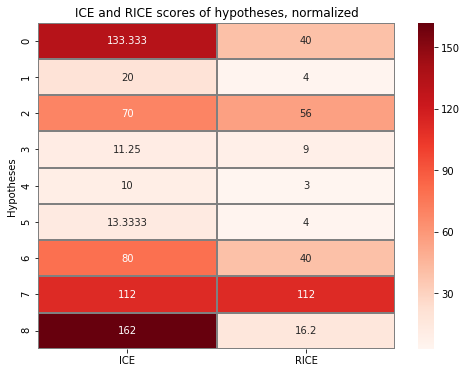

In [22]:
#visualizing ICE and RICE scores for a list of hypotheses

plt.figure(figsize=(8,6))
plt.title('ICE and RICE scores of hypotheses, normalized')
ax = sns.heatmap(hypotheses_score_change, annot=True, linewidth=1, fmt='g', linecolor='gray', cmap='Reds')
ax.set_ylabel('Hypotheses')
plt.show()

<Figure size 864x576 with 0 Axes>

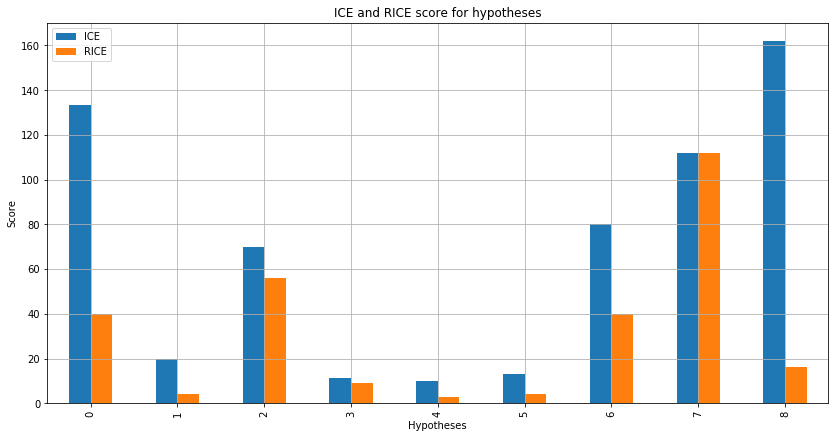

In [79]:
#visualizing ICE and RICE scores for a list of hypotheses

plt.figure(figsize=(12,8))
ax = hypotheses_score_change.plot(kind="bar", figsize=(14,7), grid=True, title='ICE and RICE score for hypotheses')
ax.set_xlabel('Hypotheses')
ax.set_ylabel('Score')
plt.show()

<a id="section1_3c"></a>

What changed when we rank hypotheses according to RICE and not ICE? We see that hypothesis 8, which had the highest ICE score, goes down in the RICE score list, since its Reach parameter (1) is the lowest of all hypotheses. Hypothesis 0 has the second place in ICE score list, and third in RICE list, its Reach parameter is relatively low (3). Third on ICE score list comes hypothesis 7, which got first position in RICE score since its Reach parameter is the highest possible (10). Hypotheses 6 and 2 kept their places in top 5 hypotheses (theis Reach parameters are 5 and 8).
Overall we see, that adding Reach parameter to our assesing can drastically change the picture, leaving us in the end with hypotheses 7 ("Add a subscription form to all the main pages. This will help you compile a mailing list"), 2 ("Add product recommendation blocks to the store's site. This will increase conversion and average purchase size"), 0 ("Add two new channels for attracting traffic. This will bring 30% more users") and 6 ("Show banners with current offers and sales on the main page. This will boost conversion").

## Part 2. A/B Test Analysis

You carried out an A/B test and got the results described in the files orders_us.csv and visits_us.csv.
Task
Analyze the A/B test:

In [23]:
#building an array with unique paired date group values

datesGroups = orders[['date', 'group']].drop_duplicates()

In [24]:
#aggregate cumulative daily data on orders

ordersAggregated = datesGroups.apply(lambda x: 
                                     orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg
                                     ({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}),
                                    axis=1).sort_values(by=['date', 'group'])

In [25]:
#aggregate cumulative data on visits

visitsAggregated = datesGroups.apply(lambda x:
                                    visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg
                                    ({'date':'max', 'group':'max', 'visits':'sum'}), axis=1).sort_values(by=['date', 'group'])

In [26]:
#merging tables into one and giving its columns descriptive names

cumulativeData = ordersAggregated.merge(visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

<a id="section2_1"></a>

### Graph cumulative revenue by group. 

In [27]:
#DataFrame with cumulative orders and cumulative revenue by day, group A

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']].copy()

In [28]:
#DataFrame with cumulative orders and cumulative revenue by day, group B

cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']].copy()

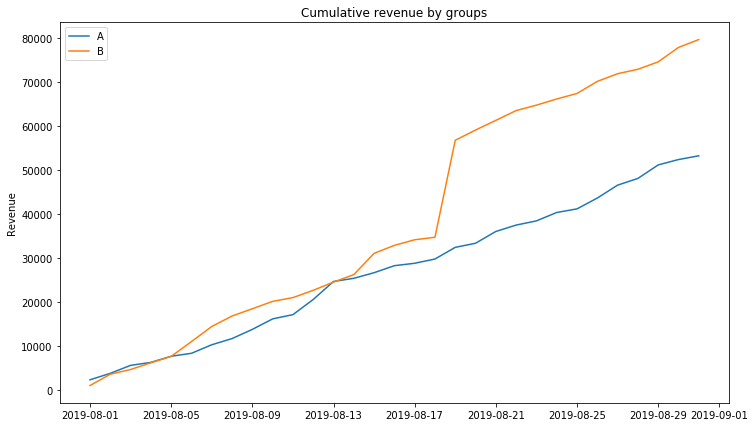

In [80]:
#visualizing cumulative revenue by group

plt.figure(figsize=(12,7))
plt.title('Cumulative revenue by groups')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.ylabel('Revenue')
plt.legend()
plt.show()

<a id="section2_1c"></a>

Revenue is rising, that's a good sign. For group B, we see a sudden spike between August 17 and August 21, this might be due to the presence of big, expensive orders.

<a id="section2_2"></a>

### Graph cumulative average order size by group. 

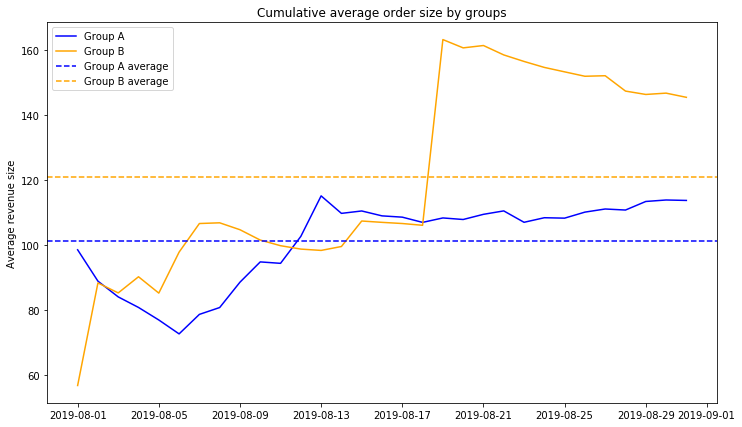

In [84]:
#visualizing cumulative average order size by groups

plt.figure(figsize=(12,7))
plt.title('Cumulative average order size by groups')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], color='blue', label='Group A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], color='orange', label='Group B')
plt.axhline((cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders']).mean(), color='blue', linestyle='--', label='Group A average')
plt.axhline((cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders']).mean(), color='orange', linestyle='--', label='Group B average')
plt.ylabel('Average revenue size')
plt.legend()
plt.show()

<a id="section2_2c"></a>

Average order size stabilizes by the end of the test, although we still see this huge spike for group B, that might be due to the presence of large, expensive orders.

<a id="section2_3"></a>

### Graph the relative difference in cumulative average order size for group B compared with group A. 

In [31]:
#gathering the data into one DataFrame

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

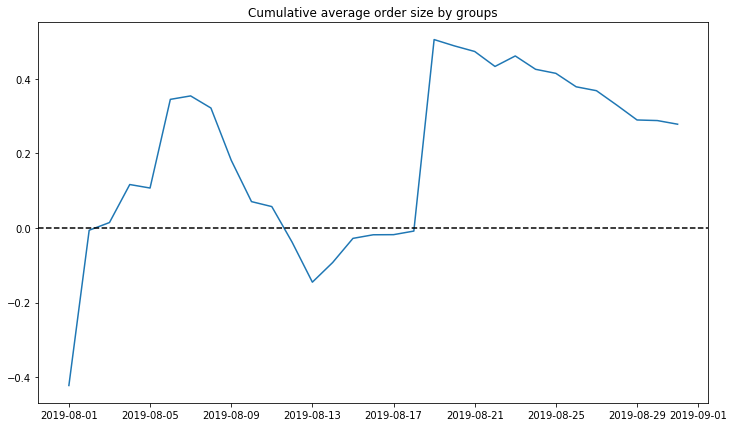

In [32]:
#visualizing relative difference in cumulative average order size
plt.figure(figsize=(12,7))
plt.title('Cumulative average order size by groups')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) /
        (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) -1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


<a id="section2_3c"></a>

We see several spikes in difference, which means that we probably have some big orders and outliers.

<a id="section2_4"></a>

### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. 

In [33]:
#calculating cumulative conversion

cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

In [34]:
#selecting data on group A

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

In [35]:
#selecting data on group B

cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

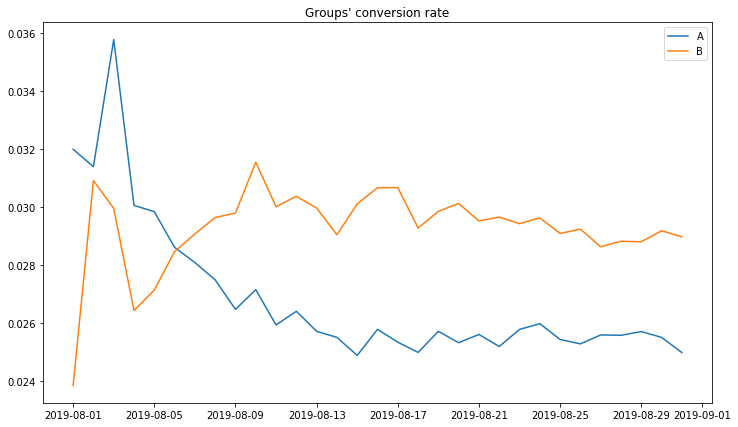

In [36]:
#visualizing each group's conversion rate

plt.figure(figsize=(12,7))
plt.title("Groups' conversion rate")
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.show()

<a id="section2_4c"></a>

We see some fluctuations in the beginning of the test, and by the end we see it stabilized and slowly decreasing for both groups, although group B's conversion rate is higher.

<a id="section2_4_0"></a>

#### Relative gain in conversion for group B compared with group A. 

In [37]:
#merging cumulative conversions into one DataFrame

mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], 
                                                                            left_on='date', right_on='date', 
                                                                           how='left', suffixes=['A', 'B'])

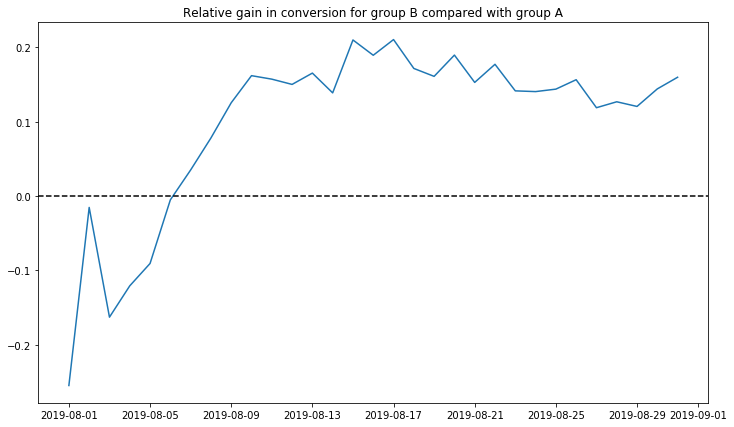

In [41]:
#visualizing relative conversion gain

plt.figure(figsize=(12,7))
plt.title('Relative gain in conversion for group B compared with group A')
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] -1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

<a id="section2_4_0c"></a>

We see fluctuations in the beginning of the test, after a week graph stabilizes and shows us, that conversion rate is higher in group B than it is in group A.

<a id="section2_5"></a>

### Plot a scatter chart of the number of orders per user. 

In [36]:
#finding the number of orders per user

ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby(
'visitorId', as_index=False).agg({'transactionId':'nunique'})

ordersByUsers.columns = ['visitorId', 'orders']

In [37]:
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


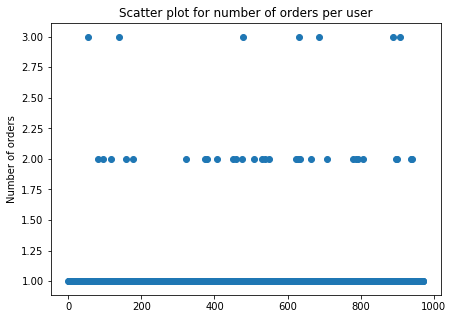

In [38]:
#visualising number of orders per user

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(7,5))
plt.title('Scatter plot for number of orders per user')
plt.ylabel('Number of orders')
plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

<a id="section2_5c"></a>

We see that mostly users make 1 order, small part of them make 2 orders and very few make 3.  (in this case, we might consider 3 orders an outlier, although according to common sense it doesn't seem like one).

<a id="section2_6"></a>

### Define the point at which a data point becomes an anomaly.
Calculate the 95th and 99th percentiles for the number of orders per user. 

In [39]:
#calculating 95th and 99th percentile

print(np.percentile(ordersByUsers['orders'], [95,99]))

[1. 2.]


<a id="section2_6c"></a>

The variance of number of orders isn't that big - it's either 1, 2, or 3 orders. We see that 95% of users made no more than 1 order, and 99% of users made no more than 2 orders. Therefore, in this specific case it would be reasonable to consider all number of orders more then 2 (i.e. 3 orders) an outlier.

<a id="section2_7"></a>

### Plot a scatter chart of order prices. 

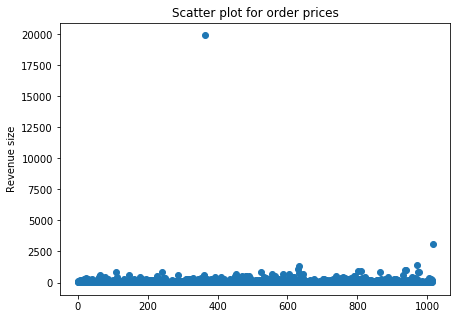

In [40]:
#visualising order prices

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(7,5))
plt.title('Scatter plot for order prices')
plt.ylabel('Revenue size')
plt.scatter(x_values, orders['revenue'])
plt.show()

<a id="section2_7c"></a>

We see that for almost all orders size is under 1500, but there clearly are outliers.

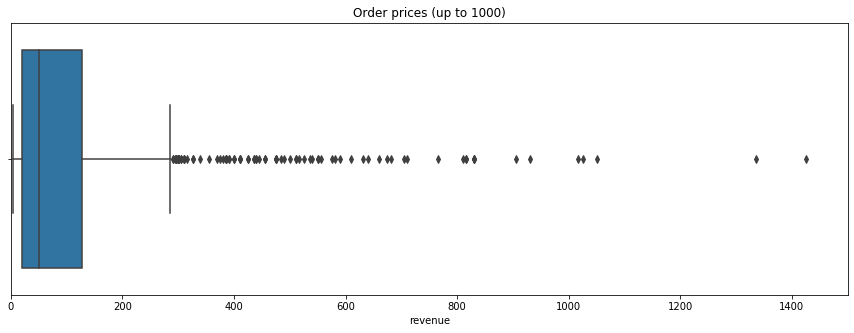

In [60]:
#visualizing order prices in more informative way

plt.figure(figsize=(15,5))
plt.title('Order prices (up to 1000)')
plt.axis([0, 1500, 0, 1])
ax = sns.boxplot(x=orders['revenue'])
plt.show()

When we look at more detailed graph, we see that mostly we have orders with price below 200, and we also got some orders between 200 and 700, and very few orders have price above 700.

<a id="section2_8"></a>

### Define the point at which a data point becomes an anomaly.
Calculate the 95th and 99th percentiles of order prices. 

In [41]:
print(np.percentile(orders['revenue'], [95,99]))

[414.275 830.3  ]


<a id="section2_8c"></a>

Calculating percentiles, we see that no more than 5% of orders cost more than 414, and no more than 1% cost more than 830.
Given that range, we can consider all orders with cost above 800 an outliers.

<a id="section2_9"></a>

### Find the statistical significance of the difference in conversion between the groups using the raw data. 

In [42]:
#creating variables to store uset IDs and orders they've made for group A

ordersByUsersA = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersA.columns = ['visitorId', 'orders']

In [43]:
#creating variables to store uset IDs and orders they've made for group B

ordersByUsersB = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersB.columns = ['visitorId', 'orders']

In [44]:
#creating variables with number of orders from group A (users who didn't order will have 0)

sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(
    visits[visits['group'] == 'A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

In [45]:
#creating variables with number of orders from group B (users who didn't order will have 0)

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(
    visits[visits['group'] == 'B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

In [46]:
#checking the size of the samples

print('Size of sample A:', len(sampleA))
print('Size of sample B:', len(sampleB))

Size of sample A: 18736
Size of sample B: 18916


In [47]:
#reducing the size of sample B so statistical test would have higher power

sampleBForTest = sampleB.sample(18736)

In [48]:
#applying statistical criterion to find the statistical significance of the difference in conversion between the groups

print('p-value: '"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleBForTest)[1]))
print('Relative conversion gain: '"{0:.2%}".format(sampleB.mean() / sampleA.mean() -1))

p-value: 0.006
Relative conversion gain: 15.98%


Our null hypothesis here is: "There's no statistically significant difference in conversion rate between the groups A and B, they're the same". Our alternative hypothesis is: "There is a statistically significant difference in conversion rate between group A and group B".

<a id="section2_9c"></a>

The p-value is considerably smaller than 0.05, so we reject the null hypothesis (that there's no statistically significant difference in conversion between the groups).
Therefore, we can conclude that the relative difference in conversion of 16% (group B comparing to group A) is statistically significant.

<a id="section2_10"></a>

### Find the statistical significance of the difference in average order size between the groups using the raw data. 

In [49]:
#applying statistical criterion to find the statistical significance of the difference in average order size between the groups

print('p-value: '"{0:.3f}".format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], 
                                                     orders[orders['group'] == 'B']['revenue'])[1]))

print('Relative difference in average order size: '"{0:.2%}".format(orders[orders['group'] == 'B']['revenue'].mean() / 
                                                                    orders[orders['group'] == 'A']['revenue'].mean() -1))

p-value: 0.431
Relative difference in average order size: 27.83%


Our null hypothesis here: "There's no statistically significant difference in average order size between group A and group B, they're the same". Our alternative hypothesis is: "The difference in average order size between the groups is statistically significant".

<a id="section2_10c"></a>

The p-value is considerably higher than 0.05, so there's no reason to reject the null hypothesis (that there's no difference between groups in terms of average order size). Nonetheless, we see that average order size for group B is much bigger (27% difference).

<a id="section2_11"></a>

### Find the statistical significance of the difference in conversion between the groups using the filtered data. 

In [50]:
#defining anomalous users

usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > 800]['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

In [51]:
#finding their number

print('Number of abnormal users: ', abnormalUsers.shape[0])

Number of abnormal users:  22


In [52]:
#creating sample of filtered data for group A

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'], 
                             pd.Series(0, index=np.arange(visits[visits['group'] == 'A']['visits'].sum() - 
                                                          len(ordersByUsersA['orders'])), name='orders')], axis=0)

In [53]:
#creating sample of filtered data for group B

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'], 
                             pd.Series(0, index=np.arange(visits[visits['group'] == 'B']['visits'].sum() - 
                                                          len(ordersByUsersB['orders'])), name='orders')], axis=0)

In [54]:
#checking the size of the samples


print('Size of filtered sample A:', len(sampleAFiltered))
print('Size of filtered sample B:', len(sampleBFiltered))

Size of filtered sample A: 18722
Size of filtered sample B: 18908


In [55]:
#reducing the size of sample B so the statistical test will have higher power

sampleBFilteredForTest = sampleB.sample(18722)

In [56]:
#applying statistical criterion to find the statistical significance of the difference in conversion between the groups

print('p-value: '"{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFilteredForTest)[1]))
print('Relative conversion gain: '"{0:.2%}".format(sampleBFiltered.mean() / sampleAFiltered.mean() -1))

p-value: 0.002
Relative conversion gain: 19.80%


Our null hypothesis here is: "There's no statistically significant difference in conversion rate between the groups A and B, they're the same". Our alternative hypothesis is: "There is a statistically significant difference in conversion rate between group A and group B".

<a id="section2_11c"></a>

We see that there's still statistically significant difference in conversion between the groups, same as for raw data.
Relative gain slightly increased, from 16% to 19%, group B'results are better than group A's.

<a id="section2_12"></a>

### Find the statistical significance of the difference in average order size between the groups using the filtered data. 

In [57]:
#applying statistical criterion to find the statistical significance of the difference in average order size between the groups

print('p-value: '"{0:.3f}".format(stats.mannwhitneyu(orders[np.logical_and(
orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                                         orders[np.logical_and(
orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])
                      [1]))

print('Relative difference in average order size: '"{0:.2%}".format(
orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() /
orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() -1))

p-value: 0.487
Relative difference in average order size: 1.01%


Our null hypothesis here: "There's no statistically significant difference in average order size between group A and group B, they're the same". Our alternative hypothesis is: "The difference in average order size between the groups is statistically significant".

<a id="section2_12c"></a>

The p-value is still much higher than 0.05, therefore we can conclude that there's no difference in average order size between the groups. Relative difference decreased to 1% when we used filtered data (for raw data it was 27%).

<a id="section2_13"></a>

### Make a decision based on the test results. 
The possible decisions are: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.

<a id="section2_13c"></a>

After exploring the data, building graphs and excluding anomalies, we see that neither raw nor filtered data revealed any statistically significant difference in average order size. 

We also see that both raw and filtered data revealed statistically significant difference in conversion rate between the groups.

The graph showing the difference in conversion between the groups tells us that although conversion is slightly going down in general, group B's results are considerably (around 20%) higher, than group A's results

The graph showing the difference in average order size tells us that group B's results are better, but it happened due to outlier, and in the end the difference turned out to be statistically insignificant.

In the beginning we assessed hypotheses with ICE and RICE framework. The hypotheses with highest RICE score included hypotheses about boosting conversion. Let's assume that this is what we want to check

Based on the facts listed above, we can conclude that the test is sucessfull, conversion rate grew significantly for group B, and although the average order size didn't change, we can consider group B's the leader, stop the test, and move on to the next hypotheses.